## <center>Capstone Project </center>

<center> 18th March </center>

Group Team
- Ethan Lindt
- Andrew Olsen
- Alessandro Caruso

<hr>

<p style="background-color: darkgreen;"><strong>Done:</strong>&nbsp;</p>


- Main exploration on c110 (called df110)
- Data Cleaning
- Exploration of main variables
- Creation of new features
- Approximation of ISI lead time
- Inspection of relationships between regressors and waiting time 
- Initial definition of an efficient delivery
- Grouping of product and suppliers of which the ordered quantity has an impact on waiting time.
- (Very) preliminary linear regression to assess impact of coefficients
- Initial Data viz

<p style="background-color: navy;"><strong>In Progress:</strong>&nbsp;</p>

- Definition of efficient delivery
- ad-hoc cleaning and feature engineering
- Exploration of df126

<p style="background-color: darkred;"><strong>Next Steps:</strong>&nbsp;</p>

- Cross-Analysis with the other datasets
- Predictive models
- What-if scenarios
- Comprehensive and Interactive Data visualizations


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycodestyle
import openpyxl

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('magma')

In [3]:
df_110 = pd.read_excel('USD PO Line Detail Report.xlsx', sheet_name = 0, engine = 'openpyxl')
df_126 = pd.read_excel('USD PO Line Detail Report.xlsx', sheet_name = 1, engine = 'openpyxl')
df_297 = pd.read_excel('USD PO Line Detail Report.xlsx', sheet_name = 3, engine = 'openpyxl')
df_298 = pd.read_excel('USD PO Line Detail Report.xlsx', sheet_name = 4, engine = 'openpyxl')

## Data Cleaning

In [4]:
df_110 = df_110[~df_110.iloc[:,0].str.startswith('1')].drop(columns= ['Confirmed Delivery Date'], axis = 1)
df_126 = df_126[~df_126.iloc[:,0].str.startswith('1')].drop(columns= ['Confirmed Delivery Date'], axis = 1)
df_297 = df_297[~df_297.iloc[:,0].str.startswith('1')].drop(columns= ['Confirmed Delivery Date'], axis = 1)
df_298 = df_298[~df_298.iloc[:,0].str.startswith('1')].drop(columns= ['Confirmed Delivery Date'], axis = 1)


df_110 = df_110[~df_110['Actual Delivery Date'].isna()]
df_126 = df_126[~df_126['Actual Delivery Date'].isna()]
df_297 = df_297[~df_297['Actual Delivery Date'].isna()]
df_298 = df_298[~df_298['Actual Delivery Date'].isna()]


df_110['Actual Delivery Date'] = df_110['Actual Delivery Date'].values.astype('datetime64[D]')
df_126['Actual Delivery Date'] = df_126['Actual Delivery Date'].values.astype('datetime64[D]')
df_297['Actual Delivery Date'] = df_297['Actual Delivery Date'].values.astype('datetime64[D]')
df_298['Actual Delivery Date'] = df_298['Actual Delivery Date'].values.astype('datetime64[D]')


df_110['PO Creation Date'] = df_110['PO Creation Date'].values.astype('datetime64[D]')
df_126['PO Creation Date'] = df_126['PO Creation Date'].values.astype('datetime64[D]')
df_297['PO Creation Date'] = df_297['PO Creation Date'].values.astype('datetime64[D]')
df_298['PO Creation Date'] = df_298['PO Creation Date'].values.astype('datetime64[D]')



### Dropping Products with Same Order Quantity

In [5]:
df_110 = df_110.rename(columns={"Part Number": "Part_Number"})
df_110_unique = df_110.groupby(['Part_Number', 'BP Code'])['Ordered Qty'].nunique().reset_index(name='count')

df_110_unique.Part_Number = df_110_unique.Part_Number.astype('str')
df_110_unique['BP Code'] = df_110_unique['BP Code'].astype('str')
df_110_unique['PN_BP_code'] = df_110_unique.Part_Number + '_'+ df_110_unique['BP Code']
df_110_unique = df_110_unique[df_110_unique['count'] == 1].reset_index(drop = True)

df_110.Part_Number = df_110.Part_Number.astype('str')
df_110['BP Code'] = df_110['BP Code'].astype('str')
df_110['PN_BP_code'] = df_110.Part_Number + '_' + df_110['BP Code']

In [6]:
df_110 = df_110[~df_110.PN_BP_code.isin(df_110_unique.PN_BP_code)].reset_index(drop = True)

In [7]:
#drop now but we'll have to change these 181 entries later as we don't have the price.
df_110 = df_110[~df_110['Unit Price'].isna()].reset_index(drop = True)
df_126 = df_126[~df_126['Unit Price'].isna()].reset_index(drop = True)
df_297 = df_297[~df_297['Unit Price'].isna()].reset_index(drop = True)
df_298 = df_298[~df_298['Unit Price'].isna()].reset_index(drop = True)

## (Initial) Features Engineering

In [8]:
df_110['true_dem_lt'] = df_110.apply(lambda x: np.busday_count(x['PO Creation Date'].date(), x['Actual Delivery Date'].date()), axis = 1)

df_110['quantity_not_delivered'] = df_110['Ordered Qty'] - df_110['Delivered Qty']

df_110['Week_late'] = pd.cut(df_110.loc[:,'true_dem_lt'], bins = list(np.arange(7,70,7, dtype = int)), labels= False, right = True, include_lowest= True)
df_110.Week_late.fillna('8', inplace= True)

df_110

,PO Number,POS Number,Seq Number,BP Code,Part_Number,Ordered Qty,Delivered Qty,ISI Lead Time,Dem LT,PO Creation Date,Actual Delivery Date,Unit Price,PN_BP_code,true_dem_lt,quantity_not_delivered,Week_late
0,BAP000003,10,0,SLD063461,233313-8-0V,1.0,1.0,NaN,8.0,2020-10-19,2020-10-29,2718.31,233313-8-0V_SLD063461,8,0.0,0
1,BAP000006,10,0,SUP067572,204286-4-2V,3.0,3.0,5.0,4.0,2020-10-27,2020-11-02,62.50,204286-4-2V_SUP067572,4,0.0,8
2,BAP000007,10,0,SUP034822,219636-1,19.0,16.0,130.0,169.0,2020-11-11,2021-07-02,1746.00,219636-1_SUP034822,167,3.0,8
3,BAP000007,10,1,SUP034822,219636-1,3.0,2.0,130.0,169.0,2020-11-11,2021-07-21,1746.00,219636-1_SUP034822,180,1.0,8
4,BAP000008,10,0,SUP034822,219636-1,19.0,18.0,130.0,169.0,2020-11-11,2021-07-02,1746.00,219636-1_SUP034822,167,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152851,TSS009928,10,0,SUP049443,23819R1,200.0,200.0,7.0,7.0,2021-12-14,2021-12-23,2.72,23819R1_SUP049443,7,0.0,0
152852,TSS009930,10,0,SUP049443,21535R1,40.0,40.0,7.0,7.0,2021-12-14,2021-12-23,0.03,21535R1_SUP049443,7,0.0,0
152853,TSS009930,20,0,SUP049443,1007238,50.0,50.0,7.0,7.0,2021-12-14,2021-12-23,1.54,1007238_SUP049443,7,0.0,0
152854,TSS009930,30,0,SUP049443,701643C1,100.0,100.0,7.0,7.0,2021-12-14,2021-12-23,0.06,701643C1_SUP049443,7,0.0,0


In [9]:
def _rename_df(df):
    col = ['Week_Late_'+str(i)+'.0' for i in range(0,8)]
    for j in range(len(col)):
        df = df.rename({col[j]:col[j][:-2]}, axis = 1)
    return df

df_110 = df_110.merge(pd.get_dummies(df_110.Week_late, prefix= 'Week_Late'), left_index= True, right_index= True)

df_110 = _rename_df(df_110)

In [10]:
df_110.columns

Index(['PO Number', 'POS Number', 'Seq Number', 'BP Code', 'Part_Number',
       'Ordered Qty', 'Delivered Qty', 'ISI Lead Time', 'Dem LT',
       'PO Creation Date', 'Actual Delivery Date', 'Unit Price', 'PN_BP_code',
       'true_dem_lt', 'quantity_not_delivered', 'Week_late', 'Week_Late_0',
       'Week_Late_1', 'Week_Late_2', 'Week_Late_3', 'Week_Late_4',
       'Week_Late_5', 'Week_Late_6', 'Week_Late_7', 'Week_Late_8'],
      dtype='object')

In [11]:
df_126['true_dem_lt'] = df_126.apply(lambda x: np.busday_count(x['PO Creation Date'].date(), x['Actual Delivery Date'].date()), axis = 1)

df_126['quantity_not_delivered'] = df_126['Ordered Qty'] - df_126['Delivered Qty']



In [12]:
df_297['true_dem_lt'] = df_297.apply(lambda x: np.busday_count(x['PO Creation Date'].date(), x['Actual Delivery Date'].date()), axis = 1)

df_297['quantity_not_delivered'] = df_297['Ordered Qty'] - df_297['Delivered Qty']



In [14]:
df_298['true_dem_lt'] = df_298.apply(lambda x: np.busday_count(x['PO Creation Date'].date(), x['Actual Delivery Date'].date()), axis = 1)

df_298['quantity_not_delivered'] = df_298['Ordered Qty'] - df_298['Delivered Qty']




## Data Exploration

We first start our analysis by understanding the dataset at hand. 
<br> Our main objective is to improve delivery performance by optimizing the size of the order: the order quantity. 
<br> We define an order as
- <strong> Efficient</strong>: if the supplier was able to deliver the ordered quantity within the ISI lead time (the estimated number of days given by the supplier to fulfil the order).
- <strong>  Inefficient</strong>: otherwise.

<br> If the ISI Lead Time has not been disclosed by the supplier, we estimate it. 

### Approximation of Lead Time

Lead time is the amount of days that a supplier will take in order to deliver a specific product, products may be delivered together and they take different time according to the quantity ordered. For the sake of simplicity we approximate the lead time for those orders that lack one, by taking the mean lead time asked to deliver a particular order both by product and by supplier. 

In [307]:
def avg_lt_by(dt, by_what = 'Part Number'):
    """
    This function approximates lead time, by taking the average lead time for that specific product or for that specific supplier
    """
    df = dt.copy()
    prod_med_lt = df.groupby(by_what)[['ISI Lead Time']].median().reset_index().rename(columns = {'ISI Lead Time':'median_lead_time'})
    prod_med_lt = prod_med_lt.set_index(by_what).to_dict()['median_lead_time']
    if 'ISI_lead_time' not in dt.columns: 
        df['isi_lt_missing'] = df['ISI Lead Time'].isna()
        dt['ISI_lead_time'] = df.apply(lambda x: prod_med_lt[x[by_what]] if x.isi_lt_missing == True else x['ISI Lead Time'], axis = 1)
    else: 
        df['isi_lt_missing'] = dt['ISI_lead_time'].isna()
        dt['ISI_lead_time'] = df.apply(lambda x: prod_med_lt[x[by_what]] if x.isi_lt_missing == True else x['ISI_lead_time'], axis = 1)


In [308]:
avg_lt_by(df_110, by_what = 'BP Code')
avg_lt_by(df_110)

In [309]:
print(f"We still have {df_110.ISI_lead_time.isna().sum()} rows where ISI lead time is not present, or has not been approximated so we drop this.")
df_110 = df_110[~df_110.ISI_lead_time.isna()].reset_index(drop = True)

We still have 4317 rows where ISI lead time is not present, or has not been approximated so we drop this.


In [310]:
#Deal with outliers, there are some datapoints where the Actual Delivery date is larger than PO Creation Date, we filter those rows out.
df_110 = df_110[df_110.true_dem_lt >= 0].reset_index(drop = True)

We now try to come up with the first draft of an efficiency measure: namely if the supplier was able to deliver within its disclosed estimated lead time, then we will classify that deliver as efficient, otherwise not.

In [311]:
def compute_efficiency(dt):
    df = dt.copy()
    df['efficient_shipment'] = df.apply(lambda x: 0 if x.true_dem_lt > x.ISI_lead_time else 1, axis = 1)
    return df

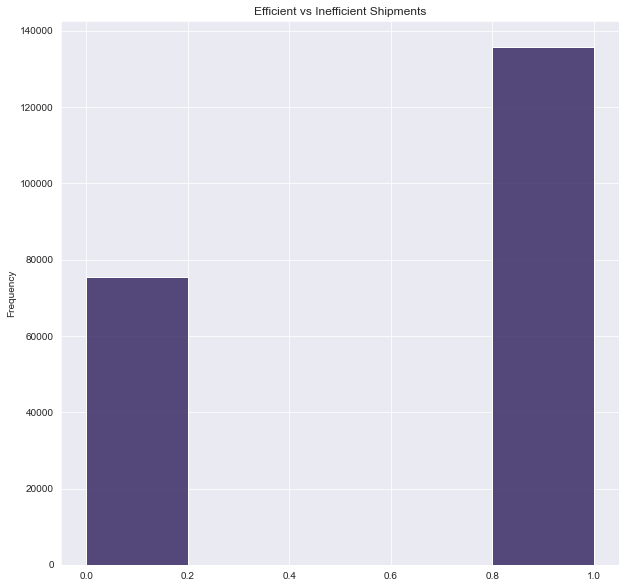

In [364]:
fig = plt.figure(figsize= (10,10))

test = compute_efficiency(df_110)
ax = sns.histplot(test.efficient_shipment, binwidth = 0.2)

ax.set_ylabel('Frequency')
ax.set_xlabel('')
plt.title('Efficient vs Inefficient Shipments')

plt.show()


In [324]:
efficiency_by_supplier = test.groupby('BP Code')[['efficient_shipment']].sum().sort_values(by = 'efficient_shipment', ascending = False)

We try to understand how many suppliers are efficient, in particular we set up a threshold and consider only those suppliers that have delivered at least 5 products in their lifetime to this factory.

In [325]:
thre = 5 #at least they delivered n products

efficiency_by_supplier = test.groupby('BP Code')[['efficient_shipment']].sum().sort_values(by = 'efficient_shipment', ascending = False)
tot_shipments_by_supplier = test.groupby('BP Code')[['PO Number']].count()
tot_shipments_by_supplier = tot_shipments_by_supplier.rename(columns= {'PO Number':'tot_n_products_shipped'})

efficiency_table = efficiency_by_supplier.merge(tot_shipments_by_supplier, left_index = True, right_index = True)
efficiency_table['perc_efficient_orders'] = efficiency_table.efficient_shipment / efficiency_table['tot_n_products_shipped']
efficiency_table = efficiency_table[efficiency_table['tot_n_products_shipped'] > thre].reset_index()
efficiency_table = efficiency_table.sort_values(by = 'perc_efficient_orders', ascending = False)



In [326]:
len(df_110['BP Code'].unique())

573

In [327]:
efficiency_table

,BP Code,efficient_shipment,tot_n_products_shipped,perc_efficient_orders
57,SUP006022,265,265,1.0
334,SUP043921,9,9,1.0
279,SUP085822,16,16,1.0
302,SUPA36011,13,13,1.0
308,SUP074595,12,12,1.0
...,...,...,...,...
454,SUP034836,0,15,0.0
455,SUPA06554,0,72,0.0
456,SUP083332,0,23,0.0
457,SUP062363,0,7,0.0


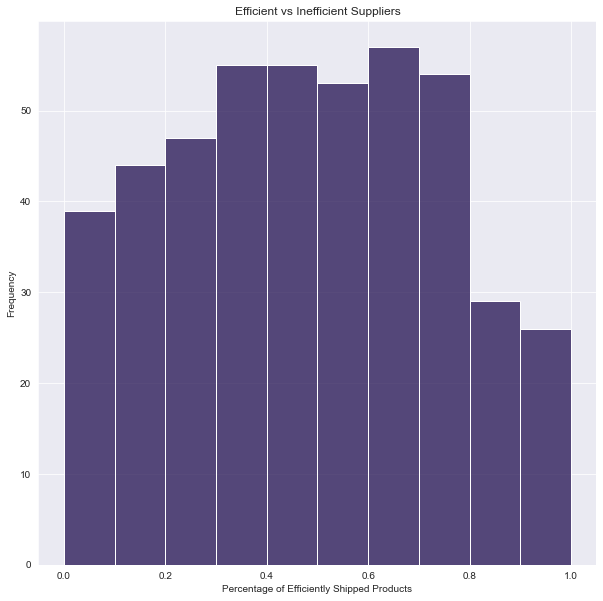

In [356]:
fig = plt.figure(figsize= (10,10))
ax = sns.histplot(efficiency_table.perc_efficient_orders)


ax.set_ylabel('Frequency')
ax.set_xlabel('Percentage of Efficiently Shipped Products')
plt.title('Efficient vs Inefficient Suppliers')

plt.show()

### Inspection of Waiting Time wrt to Ordered/Delivered/Not-Delivered Quantity in $

We now want to inspect if there is any sort of relationship between waiting time and the quantity ordered that has not been delivered. In particular, our a priori assumption would be that if an order is not entirely fulfilled then this may had either positive or negative consequences on delivery performance. <br> <br>
By <strong> positive consequences </strong> we define a lower time in delivering performance as they may had already that quantity in-stock and they sent immediately what they had. <br>
By <strong> negative consequences </strong>: they could have been late in producing that product and to fulfil the request of our company they shipped it anyway, even if it wasn't the desired quantity.

Since looking just at the quantity wouldn't be a relevant measure to compare different products, and given that we do not have weight information or other relavant dimensions that could enable us to assess the importance of that particular product, we convert everything in dollar terms and measure the relationship between waiting time and ordered quantity (in $). 
<br>
<br> Let's look at the data and understand how relavant is this variable.


In [333]:
df_110['quantity_not_delivered_dollars'] = df_110.quantity_not_delivered * df_110['Unit Price']
df_110['quantity_delivered_dollars'] = df_110['Delivered Qty'] * df_110['Unit Price']
df_110['quantity_ordered_dollars'] = df_110['Ordered Qty'] * df_110['Unit Price']
print(f"Correlation between waiting time and quantity not delivered: {df_110.true_dem_lt.corr(df_110.quantity_not_delivered_dollars)}")
print(f"Correlation between waiting time and quantity delivered: {df_110.true_dem_lt.corr(df_110.quantity_delivered_dollars)}")
print(f"Correlation between waiting time and quantity ordered: {df_110.true_dem_lt.corr(df_110.quantity_ordered_dollars)}")

Correlation between waiting time and quantity not delivered: 0.0328919612637117
Correlation between waiting time and quantity delivered: 0.18787280229029793
Correlation between waiting time and quantity ordered: 0.18625079166090763


In [334]:
"""
Simple linear regression to assess sign of the effect
"""

import statsmodels.api as sm
X = df_110[['quantity_ordered_dollars']]
X = sm.add_constant(X)
y = df_110.true_dem_lt.values
mod = sm.OLS(y, X)
res = mod.fit()


In [335]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7590.
Date:                Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:23:47   Log-Likelihood:            -1.1719e+06
No. Observations:              211214   AIC:                         2.344e+06
Df Residuals:                  211212   BIC:                         2.344e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Given the high correlation and the significant effect (even though the small magnitude of the coefficient) of quantity delivered (in dollars amount) on waiting time, we want to explore if this is something that happens for all suppliers or there's a cluster (group) of suppliers for which the quantity delivered has an higher impact on waiting time compared to other suppliers.

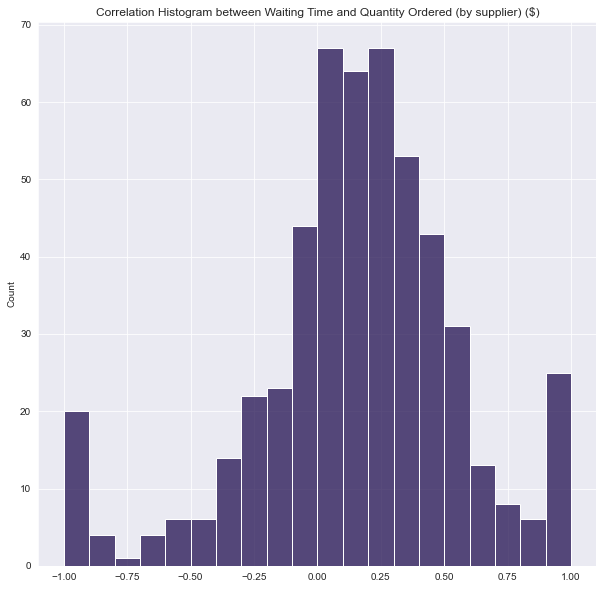

In [353]:
fig = plt.figure(figsize= (10,10))

hist_corr_0 = df_110.groupby('BP Code')[['true_dem_lt','quantity_ordered_dollars']].corr().reset_index().groupby('BP Code').first()[['quantity_ordered_dollars']]

ax = sns.histplot(hist_corr_0.quantity_ordered_dollars)

ax.set_xlabel('')
plt.title('Correlation Histogram between Waiting Time and Quantity Ordered (by supplier) ($)')

plt.show()

We see that for the majority of our suppliers the quantity delivered in dollars amount has a positive correlation with respect to lead time, suggesting that this is indeed an important variable for the majority of our suppliers to optimize the delivery performance. 

Let's see if the quantity delivered (in $ amount) is also correlated to lead time for all products now.

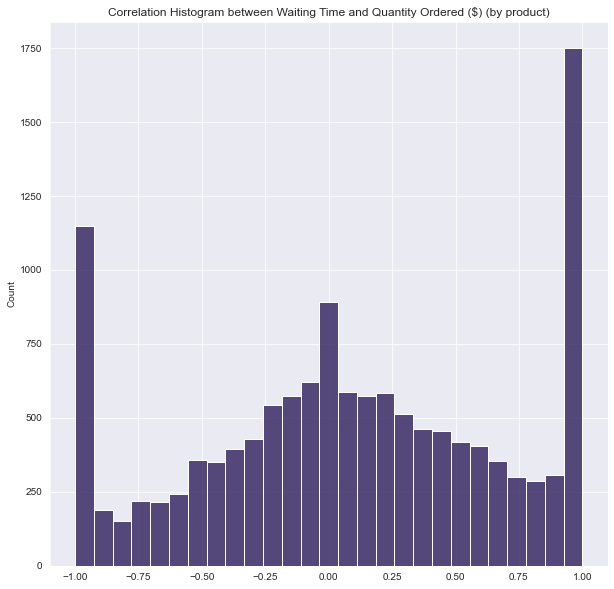

In [352]:
fig = plt.figure(figsize= (10,10))

hist_corr_1 = df_110.groupby('Part Number')[['true_dem_lt','quantity_ordered_dollars']].corr().reset_index().groupby('Part Number').first()[['quantity_ordered_dollars']]


ax = sns.histplot(hist_corr_1.quantity_ordered_dollars)

ax.set_xlabel('')
plt.title('Correlation Histogram between Waiting Time and Quantity Ordered ($) (by product)')

plt.show()

Here, we see a different result, by part even if the quantity ordered goes up the leading time is sometime negatively effected (so this is good for us:less time) and other times is instead positively affected as we would have expected (more time to deliver more goods). 
<br>
As next step, it will be interesting to see those product that are positively affected and optimize the ordered quantity (thus the delivered one only for those). 

## Questions

1) PO Number:
    - Is the PO number supposed to repeat across datasets?
    - Can goods from same PO be delivered to the same factory at different times?
#  
2) POS:
    - How do we classifify goods using POS number and why arent they all in increments of 10 (ie. 61, 62)?
# 
3) Dem lt:  
    - How was the Dem Lt calculated? We got different results. Holidays? Should we calculate different holdays based on internation suppliers?
# 
4) ISI Lead Time: 
    - ISI lead time contains lots of nulls
    - Does ISI lead time contain shipping?
    - Can we use other numbers(ie averages) to fill in Values?
#  
5) Miscellaneous
    - 470 rows across 170 dates in sheet 110 alone were delivered before the order was placed. What is happening there?
    #df_110[df_110.true_dem_lt < 0]
